In [ ]:
#Kết Nối Colab với Drive
  #from google.colab import drive
  #drive.mount('/content/drive/')

#Thư viện

In [1]:
!pip install matplotlib
!pip install numpy
!pip install scikit_learn
!pip install scipy
!pip install pandas
!pip install ipywidgets
!pip install seaborn

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [2]:
import numpy as np
import math
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('countries.csv')
data.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [ ]:
data.isna().sum()

,0
country,1
latitude,1
longitude,1
name,0


In [4]:
#Xoá các hàng có NaN
data = data.dropna(subset=['latitude','longitude'])
data.isna().sum()

,0
country,1
latitude,0
longitude,0
name,0


#1. Hiển thị tọa độ theo lat và lon của các nước

In [5]:
import plotly.express as px

x1 = data["longitude"]
x2 = data["latitude"]
x3 = data["name"]
x4 = data["country"]
fig = px.scatter(data, x1, x2, x3, x4)
fig.show()

In [6]:
# có thể vẽ cả bản đồ
import plotly.express as px
import pandas as pd

fig = px.scatter_geo(data, lat = 'latitude', lon = 'longitude', color = 'name', size_max=10,
                     title = 'Toạ độ')
fig.show()

#2. Phân cụm theo 3 thuật toán K-Means, DBSCAN, và DPC

  **2.1. Thuật toán K-Means**

**Cách thực hiện**
*  Bước 1: Chọn K là số lượng cluster cần tìm.
*  Bước 2: Chọn K điểm bất kỳ làm các center ban đầu.
*  Bước 3: Phân mỗi điểm dữ liệu vào cluster có center gần nó nhất.
*  Bước 4: Nếu việc gán dữ liệu vào từng cluster ở bước 3 không thay đổi so với vòng lặp trước nó thì ta dừng thuật toán.
*  Bước 5: Cập nhật center cho từng cluster bằng cách lấy trung bình cộng của tất các các điểm dữ liệu đã được gán vào cluster đó sau bước 3.
*  Bước 6: Quay lại bước 3.

In [10]:
#Tạo data bằng cách lấy các điểm theo phân phối chuẩn có kỳ vọng tại các điểm có tọa độ (2, 2), (8, 3) và (3, 6), ma trận hiệp phương sai giống nhau và là ma trận đơn vị.
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 400
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

Data = np.concatenate((X0, X1, X2), axis = 0)
Data

array([[0.79563473, 3.18771379],
       [4.1721594 , 2.47757428],
       [1.52369657, 2.16686851],
       ...,
       [1.98917942, 4.49441456],
       [3.37677506, 4.40219129],
       [3.53808506, 6.51294698]])

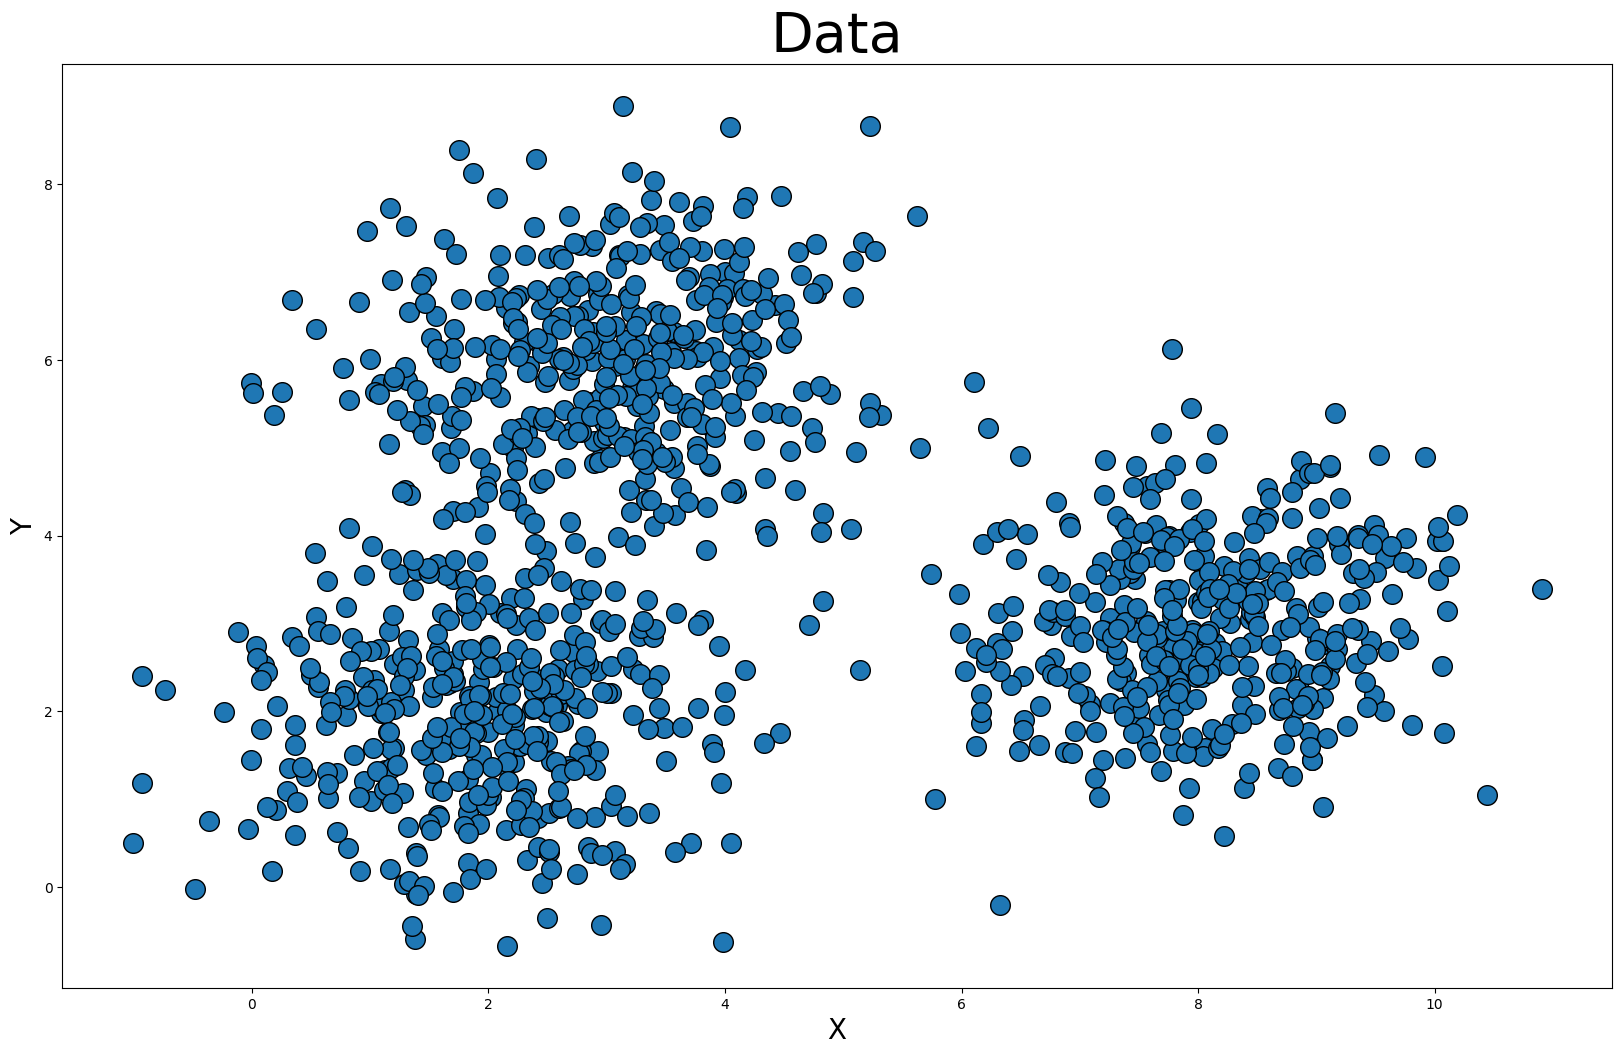

In [12]:
plt.figure(figsize=(20,12))
plt.scatter(
    Data[:, 0], Data[:, 1], # Tất cả các giá trị x từ mảng Data, y từ mảng Data
    marker='o',
    edgecolor='black', s=200    #s : kích thước các điểm
)
plt.xlabel("X", fontsize=20) #fontsize: phông chữ
plt.ylabel("Y", fontsize=20)
plt.title("Data", fontsize=40)
plt.show()

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
y_pred =kmeans.fit_predict(Data)
centers=kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



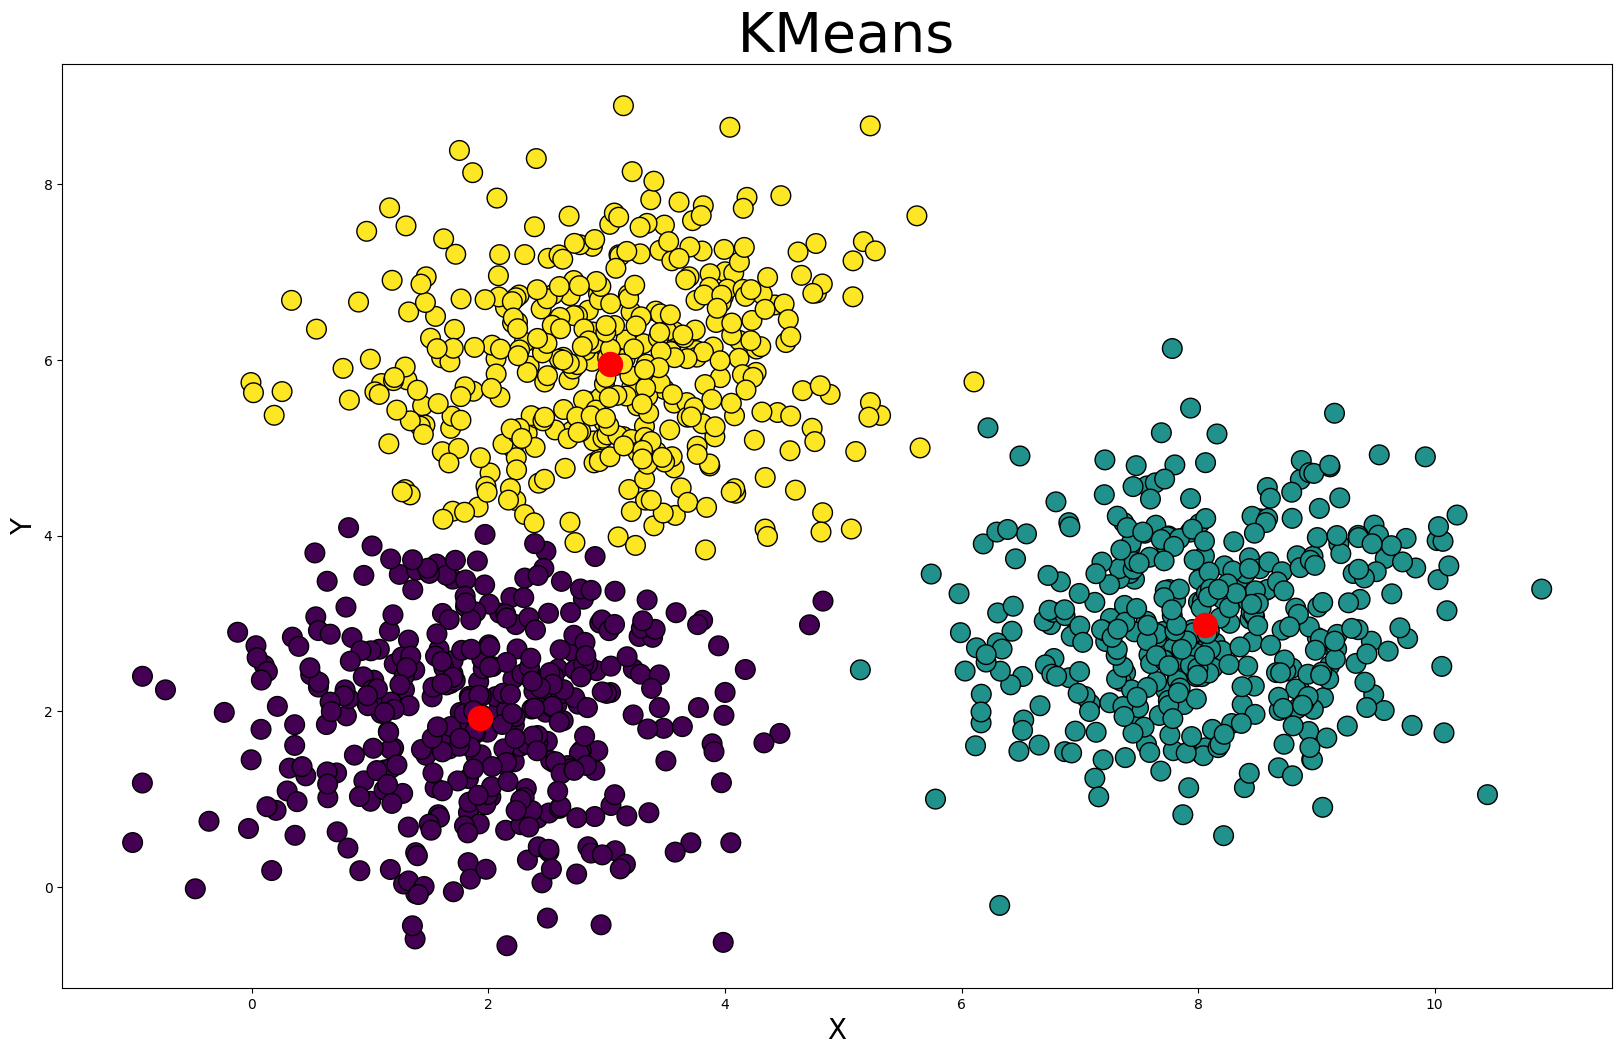

In [14]:
# Show kết quả phân cụm
plt.figure(figsize=(20,12))
plt.scatter(
    Data[:, 0], Data[:, 1],
    c=y_pred, marker='o',
    edgecolor='black', s=200
)
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)
plt.scatter(centers[:, 0], centers[:, 1], c='red',s=300)
plt.title(" KMeans", fontsize=40)
plt.show()

In [28]:
# Assuming your data points in 'Data' represent (longitude, latitude) pairs
fig = px.scatter_geo(Data, lat = 1, lon = 0,
                     # If you have names for each point, add a 'name' column to 'Data'
                     # color = 'name',
                     size_max=10,
                     title = 'Toạ độ')
fig.show()

**Hạn chế của Kmeans**
* Chúng ta cần biết số lượng cluster cần clustering
* Nghiệm cuối cùng phụ thuộc vào các centers được khởi tạo ban đầu
---

#### Phương pháp Elbow cho giá trị tối ưu của k trong KMeans

Distorsion: Trung bình cộng bình phương khoảng cách giữa tâm cụm đến các điểm còn lại.

Một mô hình tốt là mô hình có giá trị distorsion thấp và số lượng cụm phù hợp. Tuy nhiên, khi số lượng cụm quá lớn, giá trị distorsion có thể không giảm nhiều nữa hoặc thậm chí tăng lên do sự phân tán của các điểm dữ liệu trong mỗi cụm. Do đó, để tìm một mô hình tốt, chúng ta cần tìm một sự cân bằng giữa giá trị distorsion và số lượng cụm phù hợp cho bộ dữ liệu.

Chọn số cụm hợp lý bằng cách: chọn điểm mà độ giảm distorsion bắt đầu chậm lại.

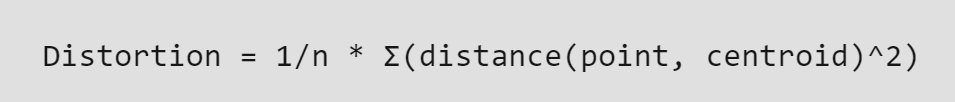

In [15]:
distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Data[:,[0, 1]])
    distorsions.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

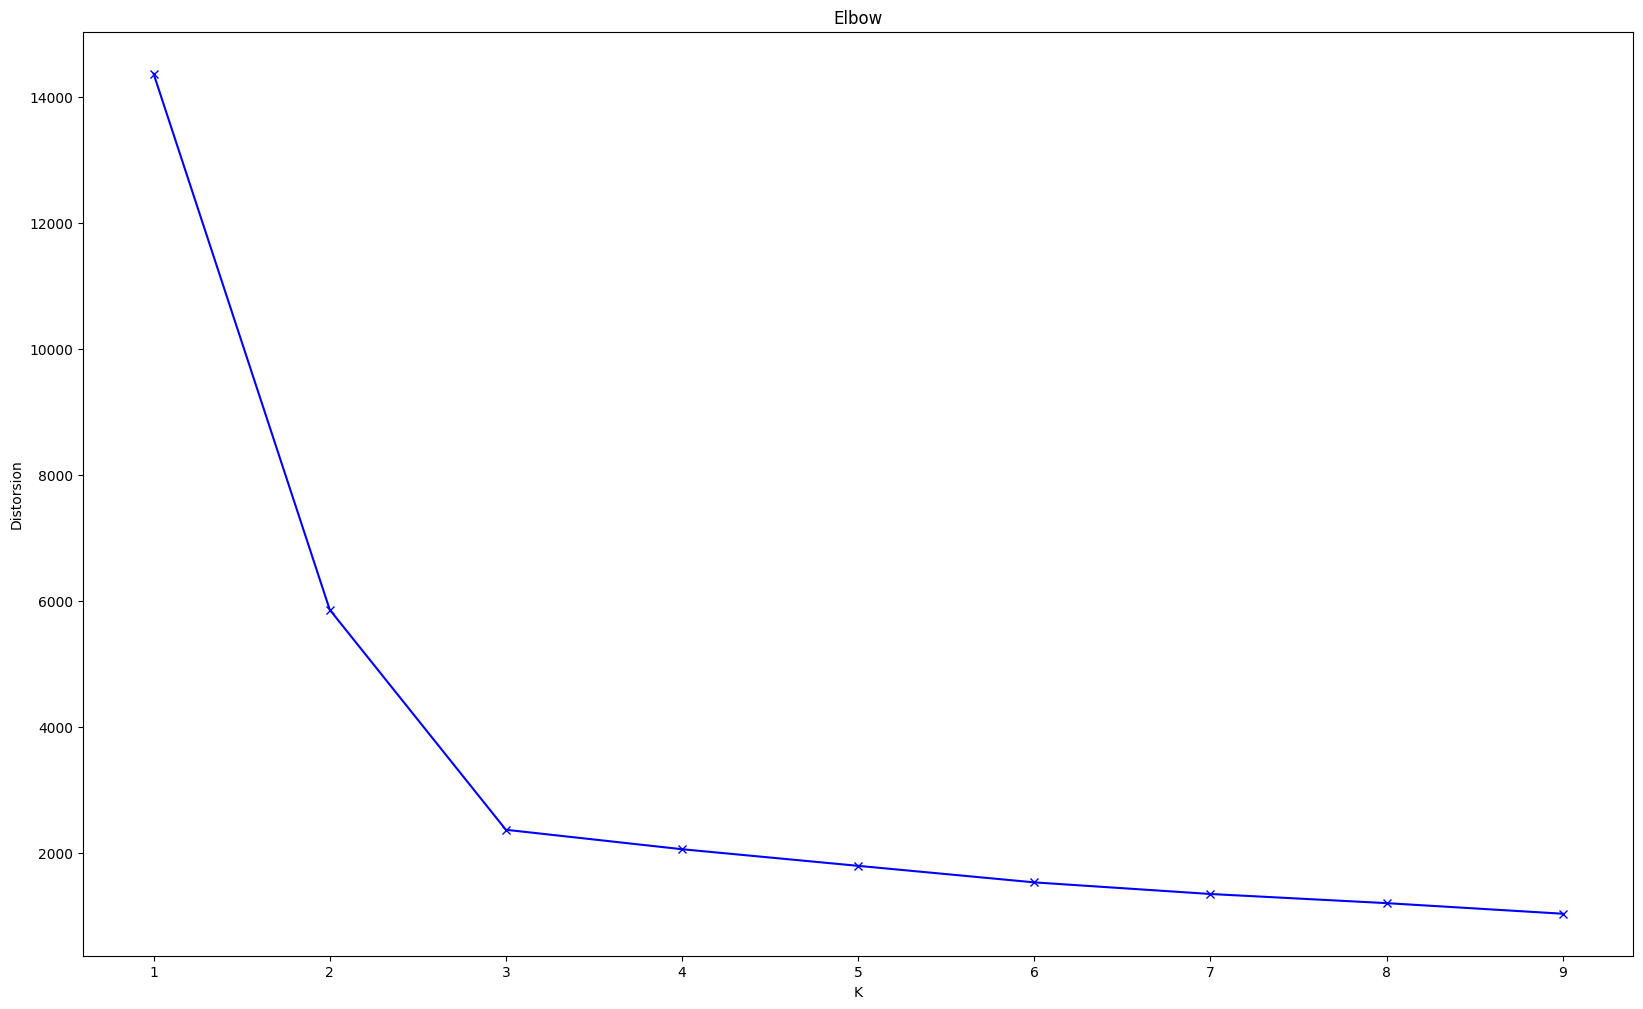

In [16]:
plt.figure(figsize=(20,12))
plt.plot(range(1,10),distorsions,'bx-')
plt.xlabel("K")
plt.ylabel("Distorsion")
plt.title("Elbow")
plt.show()

#### Silhouette coefficient

Silhouette_score =  (b-a)/max(a,b)

a: trung bình khoảng cách từ điểm hiện tại đến tất cả các điểm còn lại trong cluster

b: trung bình khoảng cách từ điểm hiện tại đến tất cả các điểm ở trong cluster gần nhất

In [17]:
print(metrics.silhouette_score(Data,y_pred))
from sklearn.metrics.cluster import silhouette_score
k_values = []
silhouette_score_values = []

for i in range(2,10):
  kmeans = KMeans(n_clusters = i)
  y_pred = kmeans.fit_predict(Data)
  k_values.append(i)
  silhouette_score_values.append(metrics.silhouette_score(Data, y_pred))

0.6152571395244557


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

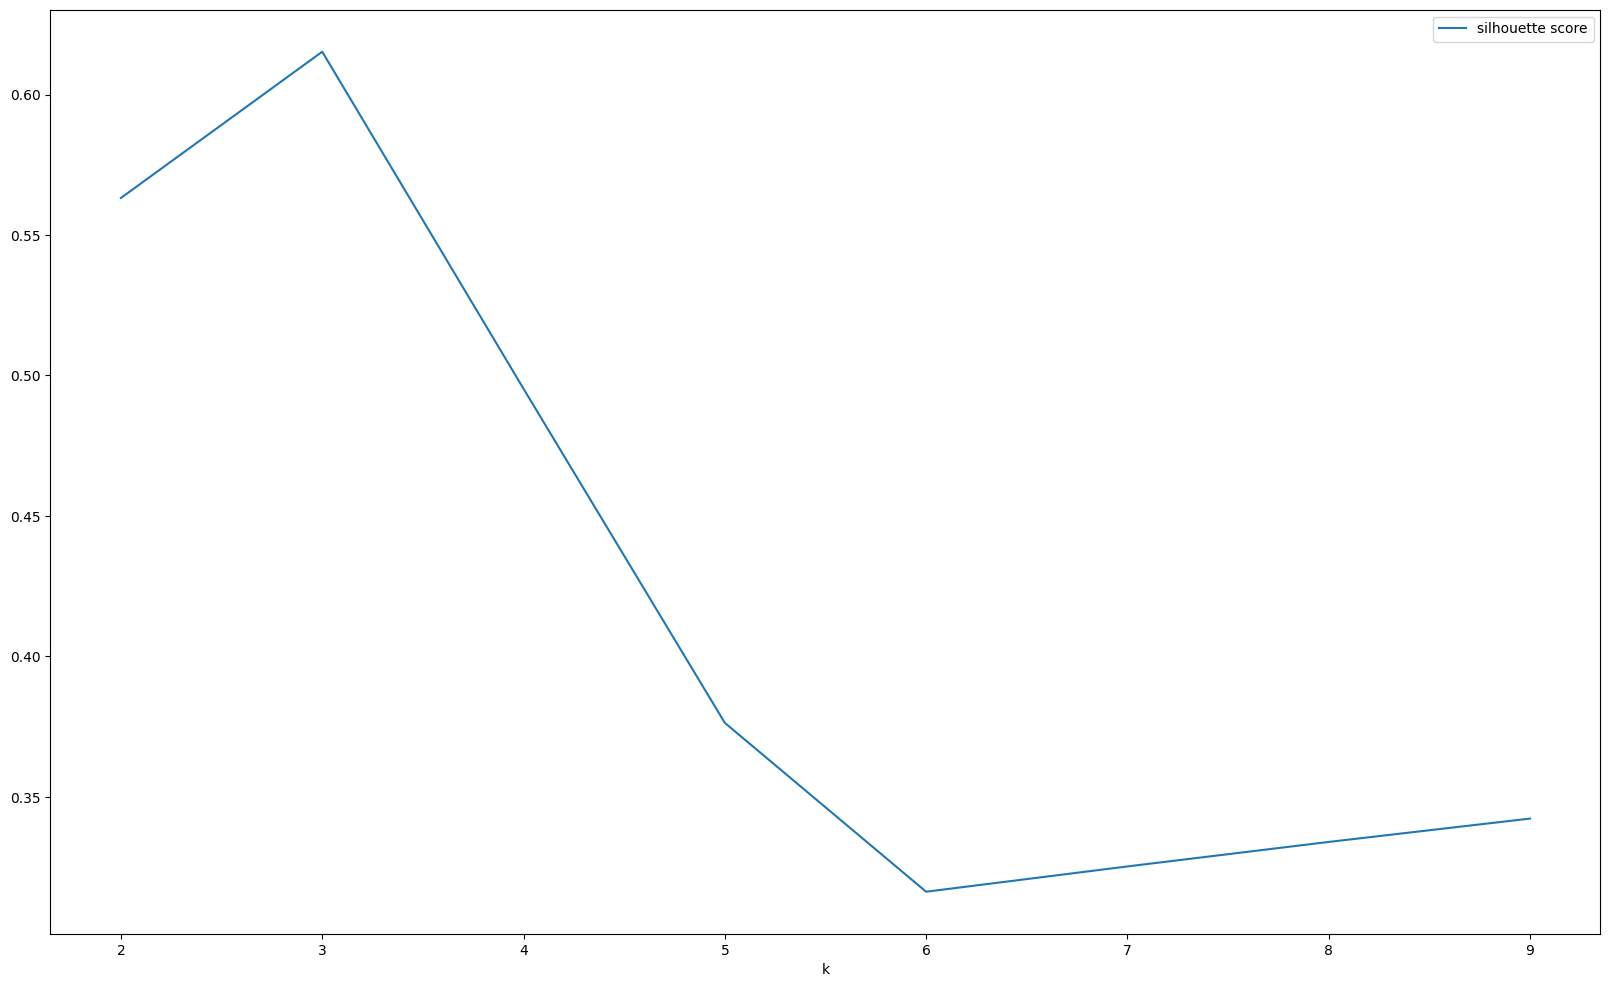

In [18]:
result = pd.DataFrame({'k': k_values, 'silhouette score': silhouette_score_values})
result.plot.line(x='k', y = 'silhouette score', figsize=(20,12))
plt.show()

  **2.2. Thuật toán DBSCAN**

eps : Nó xác định vùng lân cận xung quanh một điểm dữ liệu, tức là nếu khoảng cách giữa hai điểm nhỏ hơn hoặc bằng 'eps' thì chúng được coi là hàng xóm. Nếu giá trị eps được chọn quá nhỏ thì phần lớn dữ liệu sẽ được coi là ngoại lệ. Nếu nó được chọn rất lớn thì các cụm sẽ hợp nhất và phần lớn các điểm dữ liệu sẽ nằm trong cùng một cụm. Một cách để tìm giá trị eps dựa trên k-distance graph.

MinPts : Số lân cận tối thiểu (điểm dữ liệu) trong bán kính eps. Tập dữ liệu càng lớn thì phải chọn giá trị MinPts càng lớn. Giá trị tối thiểu của MinPts phải được chọn ít nhất là 3.


min_samples : Là MinPts nhưng tính điểm ở tâm

In [19]:
data_arr = np.array(data)

In [21]:
# Giả sử tệp CSV có hai cột cần phân cụm là 'X' và 'Y', nếu không bạn có thể thay đổi tên cột
X = data[['latitude', 'longitude']].values

Cluster
-1    244
Name: count, dtype: int64


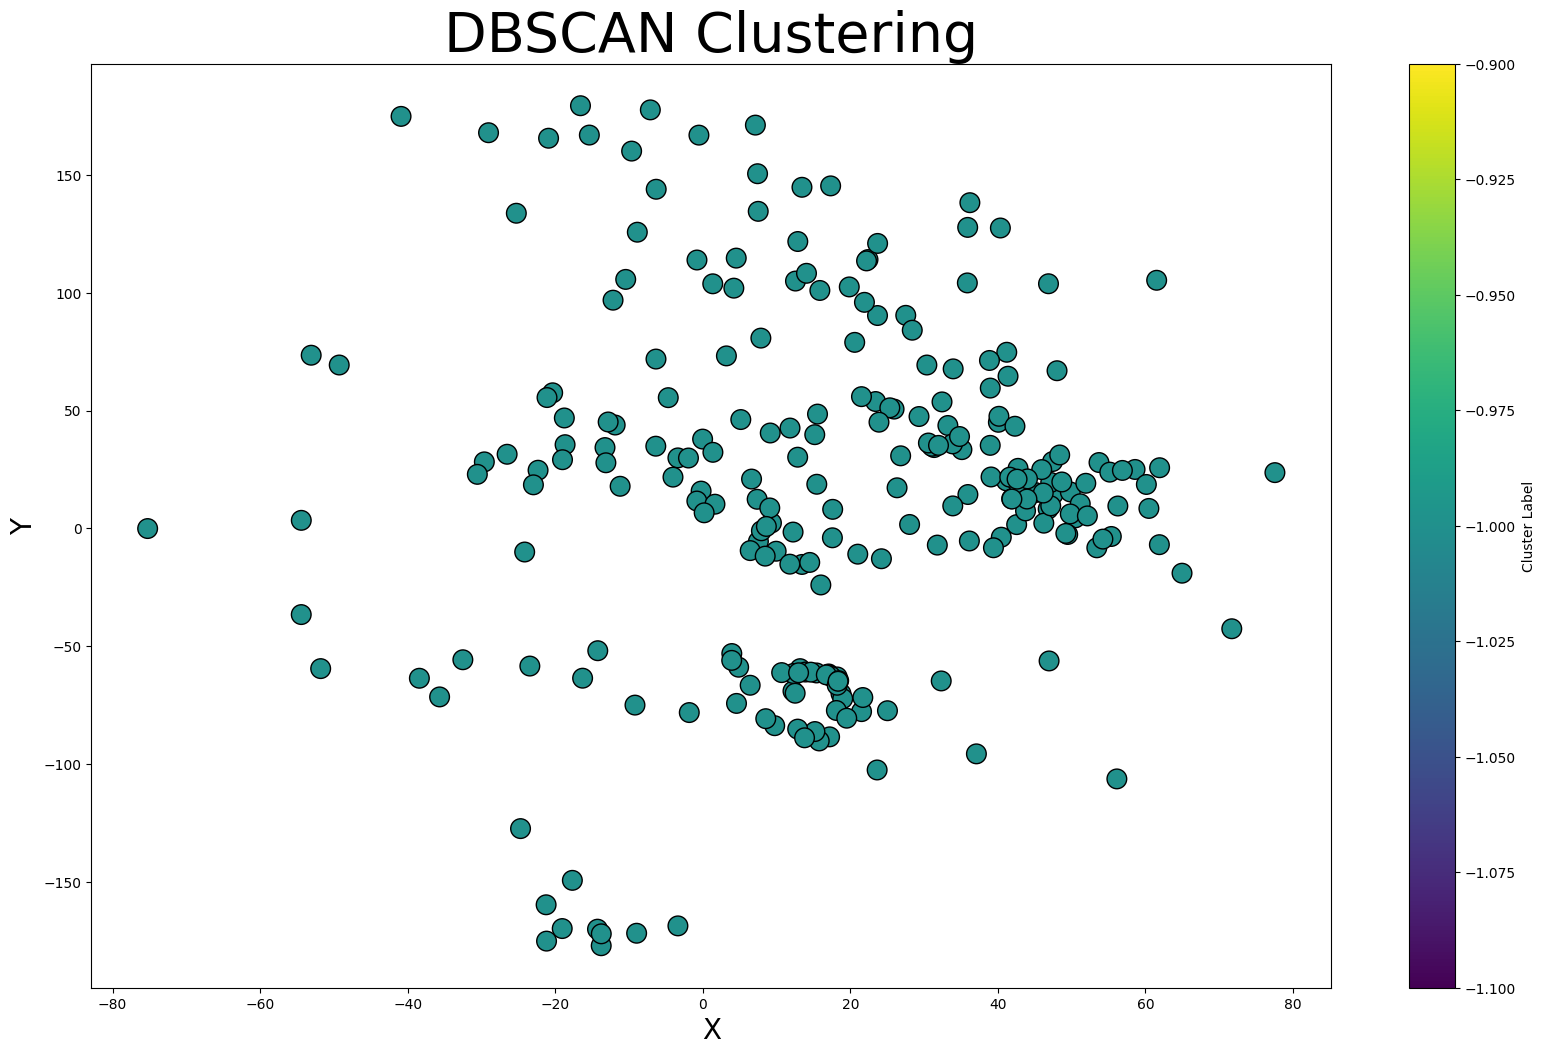

In [22]:
# Áp dụng DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Thêm nhãn phân cụm vào dataframe
data['Cluster'] = labels

# Hiển thị số lượng điểm trong mỗi cụm
print(data['Cluster'].value_counts())

# Vẽ biểu đồ phân tán với các cụm
plt.figure(figsize=(20, 12))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', s=200)
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)
plt.title("DBSCAN Clustering", fontsize=40)
plt.colorbar(label='Cluster Label')
plt.show()

In [33]:
import folium
from folium import plugins
from shapely.geometry import Point
import geopandas as gpd

# Create a DataFrame with longitude, latitude, and cluster labels
# Use the same data source that was used for clustering (data)
df = pd.DataFrame(data, columns=['longitude', 'latitude'])  # Use 'data' instead of 'Data'
df['Cluster'] = labels

# Convert DataFrame to GeoDataFrame
# Assuming your coordinates are in WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Create a Folium map centered on your data
map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Plot clusters on the map
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust as needed
for cluster in gdf['Cluster'].unique():  # Use 'Cluster' to match the column name
    if cluster == -1:  # Noise points
        color = 'gray'
    else:
        color = colors[cluster % len(colors)]
    cluster_data = gdf[gdf['Cluster'] == cluster]  # Use 'Cluster' to match the column name
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(m)

# Display the map
m

**Biểu đồ k-distance**

 Đây là biểu đồ thể hiện giá trị khoảng cách trong thuật toán k-Means clustering đến k điểm láng giềng gần nhất.

 Ứng với mỗi điểm chúng ta chỉ lựa chọn ra khoảng cách lớn nhất trong k
 khoảng cách. Những khoảng cách này trên đồ thị được sắp xếp theo thứ tự giảm dần. Các giá trị tốt của epsilon là vị trí mà biểu đồ này cho thấy xuất hiện một điểm khuỷ tay (elbow point):

 Nếu epsilon được chọn quá nhỏ, một phần lớn dữ liệu sẽ không được phân cụm và được xem là nhiễu; trong khi đối với giá trị epsilon quá cao, các cụm sẽ hợp nhất và phần lớn các điểm sẽ nằm trong cùng một cụm.

 Nói chung, các giá trị nhỏ của epsilon được ưu tiên hơn và theo quy tắc chung, chỉ một phần nhỏ các điểm nên nằm trong vùng lân cận epsilon.



Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

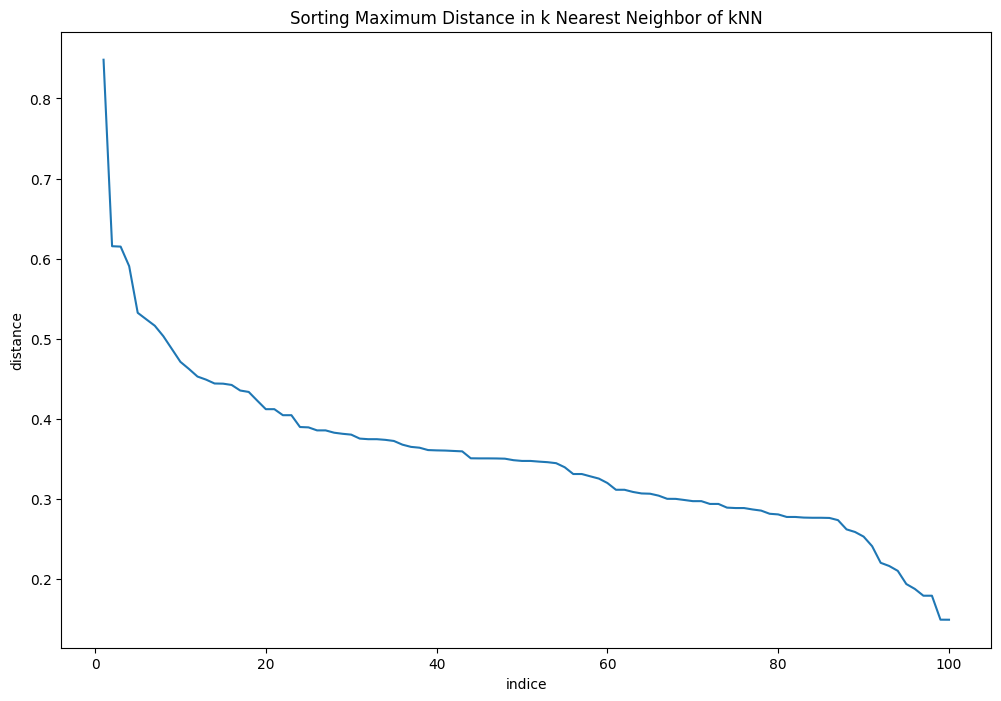

In [36]:
from sklearn.neighbors import NearestNeighbors
import numpy as np # Assuming you want to generate some random data

# Generate some random data for demonstration
X = np.random.rand(100, 2)

# Standardize the data (replace this with your actual standardization logic)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Continue with your NearestNeighbors model
neighbors = 4
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_std)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(X_std)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

* Phương pháp phân cụm phân cấp (Hierachical Clustering) không yêu cầu khai báo trước số lượng cụm.
* Thuật toán chỉ yêu cầu xác định trước thước đo về sự khác biệt giữa các cụm (không giao nhau), dựa trên sự khác biệt từng cặp giữa các quan sát trong hai cụm.
* Theo phương pháp này, chúng tạo ra những biểu diễn phân cấp trong đó các cụm ở mỗi cấp của hệ thống phân cấp được tạo bằng cách hợp nhất các cụm ở cấp độ thấp hơn bên dưới.

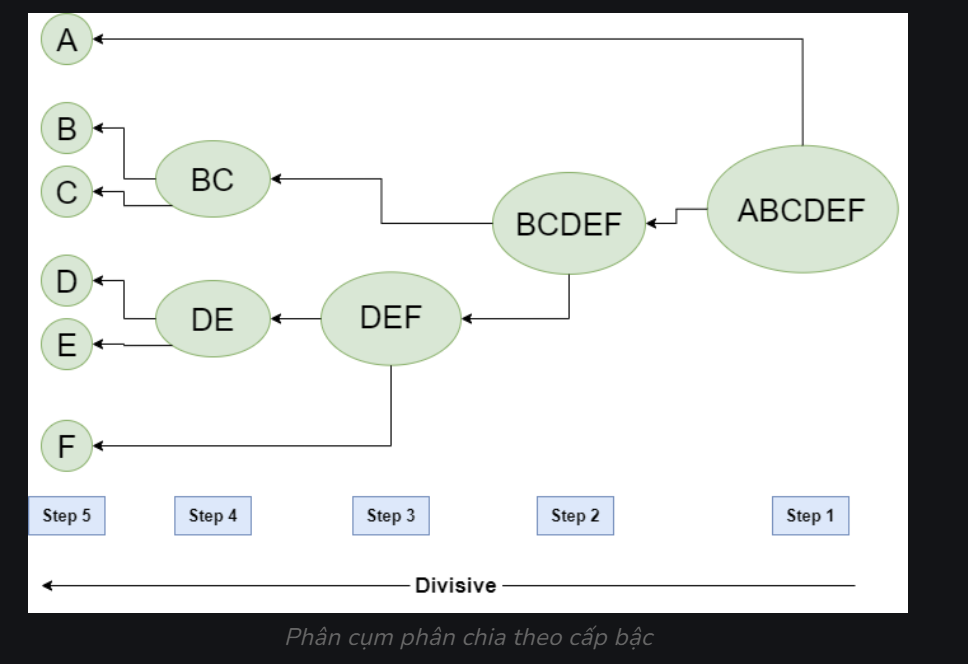

* Chiến lược hợp nhất: Chiến lược này sẽ đi theo chiều bottum-up (từ dưới lên trên). Quá trình phân cụm bắt đầu ở dưới cùng tại các node lá (còn gọi là leaf node hoặc termial node). Ban dầu mỗi quan sát sẽ được xem là một cụm tách biệt được thể hiện bởi một node lá. Ở mỗi level chúng ta sẽ tìm cách hợp một cặp cụm thành một cụm duy nhất nhằm tạo ra một cụm mới ở level cao hơn tiếp theo. Cụm mới này tương ứng với các node quyết định (non-leaf node). Như vậy sau khi hợp cụm thì số lượng cụm ít hơn. Một cặp được chọn để hợp nhất sẽ là những cụm trung gian không giao nhau.

* Chiến lược phân chia: Chiến lược này sẽ thực hiện theo chiều top-down. Tức là phân chia bắt đầu từ node gốc của đồ thị. Node gốc bao gồm toàn bộ các quan sát, tại mỗi level chúng ta phân chia một cách đệ qui các cụm đang tồn tại tại level đó thành hai cụm mới. Phép phân chia được tiến hành sao cho tạo thành hai cụm mới mà sự tách biệt giữa chúng là lớn nhất. Sự tách biệt này sẽ được đo lường thông qua một thước đo khoảng cách mà ta sẽ tìm hiểu kĩ hơn bên dưới.

  **2.3. Thuật toán DPC**

In [40]:
!pip install dpc

In [43]:
from dpc import DPC # Import DPC from dpc

X = data[['longitude', 'latitude']].values

# Áp dụng DPC
dpc = DPC()
dpc.fit(X)

# Lấy các nhãn cụm
labels = dpc.labels_

# Tạo DataFrame với kinh độ, vĩ độ và nhãn cụm
df = pd.DataFrame(X, columns=['longitude', 'latitude'])
df['cluster'] = labels

# Chuyển DataFrame thành GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Tạo bản đồ thế giới với Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Vẽ các cụm trên bản đồ
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']  # Điều chỉnh theo nhu cầu
for cluster in gdf['cluster'].unique():
    if cluster == -1:  # Điểm nhiễu
        color = 'gray'
    else:
        color = colors[cluster % len(colors)]
    cluster_data = gdf[gdf['cluster'] == cluster]
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(m)

# Hiển thị bản đồ
# m.save('dpc_world_map.html')
m

ImportError: cannot import name 'DPC' from 'dpc' (/usr/local/lib/python3.10/dist-packages/dpc/__init__.py)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors

# Giả sử tệp CSV có hai cột 'longitude' và 'latitude'
X = data[['longitude', 'latitude']].values

# Áp dụng DPC - Đây là cách triển khai cơ bản của thuật toán DPC
def density_peaks_clustering(X, cutoff_distance):
    nbrs = NearestNeighbors(radius=cutoff_distance).fit(X)
    distances, indices = nbrs.radius_neighbors(X)

    densities = np.array([len(dist) for dist in distances])
    delta = np.zeros(X.shape[0])
    nearest_higher_density = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        mask = densities > densities[i]
        if np.any(mask):
            delta[i] = np.min(np.linalg.norm(X[mask] - X[i], axis=1))
            nearest_higher_density[i] = np.where(mask)[0][np.argmin(np.linalg.norm(X[mask] - X[i], axis=1))]
        else:
            delta[i] = np.max(np.linalg.norm(X - X[i], axis=1))
            nearest_higher_density[i] = i

    gamma = densities * delta
    cluster_centers = np.argsort(-gamma)[:2]

    labels = -1 * np.ones(X.shape[0], dtype=int)
    cluster_label = 0

    for center in cluster_centers:
        labels[center] = cluster_label
        cluster_label += 1

    for i in range(X.shape[0]):
        if labels[i] == -1:
            labels[i] = labels[nearest_higher_density[i]]

    return labels

# Áp dụng DPC
labels = density_peaks_clustering(X, cutoff_distance=1.0)

# Tạo DataFrame với kinh độ, vĩ độ và nhãn cụm
df = pd.DataFrame(X, columns=['longitude', 'latitude'])
df['cluster'] = labels

# Chuyển DataFrame thành GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Tạo bản đồ thế giới với Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Vẽ các cụm trên bản đồ
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']  # Điều chỉnh theo nhu cầu
for cluster in gdf['cluster'].unique():
    if cluster == -1:  # Điểm nhiễu
        color = 'gray'
    else:
        color = colors[cluster % len(colors)]
    cluster_data = gdf[gdf['cluster'] == cluster]
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(m)

# Hiển thị bản đồ
# m.save('dpc_world_map.html')
m


#3. Nhận xét